# Intro

Work with January 2020 data. Instanteneous ozone values are here: 
https://legacy.bas.ac.uk/met/jds/ozone/data/ZXDATA19M.DAT

1. Match `mu` values to Jon's computation -- **Done**
2. Update constants to those for Jan 2020, sent by Jon
3. Match ozone values



In [1]:
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
from datetime import datetime as dt
import numpy as np

from tqdm.auto import trange, tqdm

from astropy.time import Time
from astropy.coordinates import EarthLocation, get_sun, AltAz
import astropy.units as u

import autodobson

In [2]:
def get_zenith(station, time):

        """
        Use astropy to obtain sun zenith angle at time, and station location
        """

        t = Time(time)
        l = EarthLocation(lat = station.lat * u.deg, 
                          lon = station.lon * u.deg, 
                          height = station.elevation * u.m)
        s = get_sun(t)
        s = s.transform_to(AltAz(obstime = t, location = l))
        z = s.zen.radian
        return z
    
    
def get_mu(station, zenith):

        """
        Calculate mu value, using station and sun information.
        """

        R   = station.radius
        r   = station.elevation
        h   = station.ozone_height
        SZA = zenith
        mu = (R + h) / np.sqrt(np.square(R + h) 
                               - np.square(R + r) * np.square(np.sin(SZA)))
        return mu

# Load test data

In [3]:
# Load Jon's calculation
c=pd.read_csv('https://legacy.bas.ac.uk/met/jds/ozone/data/ZXDATA19M.DAT',
             sep="\s+",
              names = ['month', 'day', 'hour','minute', 'time_code', 
                       'mu', 'z', 
                       'obs_type', 'dobs_code', 
                       'ozone'])
# add year column and date-time column
c['year']=2019*(c['month']==12)+2020*(c['month']==1)+2020*(c['month']==2)
c['dt']=pd.to_datetime(c[['year', 'month', 'day', 'hour', 'minute']])

c

,month,day,hour,minute,time_code,mu,z,obs_type,dobs_code,ozone,year,dt
0,12,6,21,32,43804.397,3.732,75.12,6,22,322,2019,2019-12-06 21:32:00
1,12,6,21,32,43804.397,3.732,75.12,7,22,315,2019,2019-12-06 21:32:00
2,12,6,23,44,43804.489,5.436,80.41,6,25,316,2019,2019-12-06 23:44:00
3,12,7,9,15,43804.886,2.099,61.89,5,95,326,2019,2019-12-07 09:15:00
4,12,7,9,15,43804.886,2.099,61.89,6,95,331,2019,2019-12-07 09:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...
975,2,1,9,22,43860.891,2.620,68.00,6,95,352,2020,2020-02-01 09:22:00
976,2,1,11,55,43860.997,2.012,60.52,5,95,302,2020,2020-02-01 11:55:00
977,2,1,11,55,43860.997,2.012,60.52,6,95,319,2020,2020-02-01 11:55:00
978,2,1,12,19,43861.014,1.968,59.77,5,95,299,2020,2020-02-01 12:19:00


# Device constants

In [4]:
# geographical data about station
s = autodobson.Station(station = 'halley6a')

# Compute `mu`

In [5]:
z = []
mu = []

for i in trange(0, c.shape[0]):
    T_i=pd.Timestamp.to_pydatetime(c['dt'][i])
    z_i  = get_zenith(s, T_i)
    mu_i = get_mu(s, z_i)
    
    z.append(z_i)
    mu.append(mu_i)

  0%|          | 0/980 [00:00<?, ?it/s]

In [6]:
c['mu1'] = mu

<AxesSubplot:xlabel='dt'>

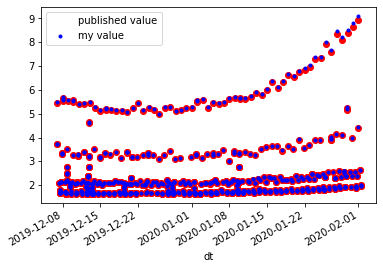

In [7]:
ax = c.plot(x = 'dt', y = 'mu', style = 'or', label = 'published value')
c.plot(x = 'dt', y = 'mu1', style = '.b', ax = ax, label = 'my value')

# Compute DS ozone

## Load raw data

In [8]:
df = pd.read_csv('zozJan20.dat', 
            sep="\s+",
            names = ['year', 'month', 'day', 'hour', 'minute', 'second', 
                     'ob', 'dob', 'A1', 'A2', 'C1', 'C2', 'D1', 'D2']) 

df['dt']=pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])

# direct sun
ds = df[df['ob']==90].reset_index(drop = True)

# umkehr
um = df[df['ob']==95].reset_index(drop = True)

# number of ds timesteps
N_ds = ds.shape[0]

## Calibration constants


In [9]:
# calibration constants for specific Dobson photometre
cal = autodobson.Calibration('031E')

In [10]:
# manually read constants from file
man_const = np.fromfile('DN031E19.DAT', sep=" ", count = 19)

In [11]:
new_cal = {}
keys = list(cal.annual_constants.keys())
for i in range(19):
    new_cal[keys[i]] = man_const[i]

In [12]:
# override constants in s
for key in new_cal.keys():
    cal.annual_constants[key] = new_cal[key]

## Compute `mu` and ozone for DS 

In [13]:
# recompute time, z and mu for DS observations
T = []
z = []
mu = []
for i in range(N_ds):        
    T_i = pd.Timestamp.to_pydatetime(ds['dt'][i])
    z_i  = get_zenith(s, T_i)
    mu_i = get_mu(s, z_i)


    T.append(T_i)
    z.append(z_i)
    mu.append(mu_i)
    
mu = np.array(mu)
z = np.array(z)

In [15]:
# compute N0, N1 for every wavelength
d = {}
for w in tqdm(['A', 'C', 'D']):
    d[w]={}
    d[w]['N0'] = []
    d[w]['N1'] = []

    for i in range(N_ds):

        angle = ds[w+'1'][i]/10 # because wavelength is on that order
        inc = int(np.floor(angle / 10))
        rn = 'R-N_'+w
        lo = 'Lo'+w

        N0 = (cal.instrument_constants[rn][inc] +
             (angle / 10 - inc) *
                 (cal.instrument_constants[rn][inc + 1] -
                  cal.instrument_constants[rn][inc]))

        N1 = N0 + cal.annual_constants[lo]

        d[w]['N0'].append(N0)
        d[w]['N1'].append(N1)
        
    d[w]['N0']=np.array(d[w]['N0'])
    d[w]['N1']=np.array(d[w]['N1'])

  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
d.keys()

dict_keys(['A', 'C', 'D'])

In [19]:
d['A']

{'N0': array([1.38763, 1.0977 , 1.0886 , 1.10953, 2.09619, 1.12136, 1.08951,
        1.38181, 1.15076, 1.49816, 1.1894 , 1.1434 , 1.38569, 1.14248,
        1.18296, 1.45602, 1.3498 , 1.23674, 1.1986 , 1.15536, 1.14524,
        1.1894 , 1.42368, 1.81197, 1.10862, 1.18388, 1.51105, 1.11772,
        1.16364, 1.4521 , 1.48052, 1.65026, 1.27246, 1.43348, 1.66262,
        1.30442, 1.63378, 1.43544]),
 'N1': array([1.34763, 1.0577 , 1.0486 , 1.06953, 2.05619, 1.08136, 1.04951,
        1.34181, 1.11076, 1.45816, 1.1494 , 1.1034 , 1.34569, 1.10248,
        1.14296, 1.41602, 1.3098 , 1.19674, 1.1586 , 1.11536, 1.10524,
        1.1494 , 1.38368, 1.77197, 1.06862, 1.14388, 1.47105, 1.07772,
        1.12364, 1.4121 , 1.44052, 1.61026, 1.23246, 1.39348, 1.62262,
        1.26442, 1.59378, 1.39544])}

In [20]:
# AD expression: applies foer mu<2.7 
oz_AD  = ((d['A']['N1'] - d['D']['N1'])/mu/cal.instrument_constants['ADcoeff']\
          - cal.instrument_constants['ADbeta']) * 1000
oz_AD  = np.round(oz_AD)
oz_AD[mu>2.7]=None

In [21]:
# AD expression: applies foer mu<4. somehow
oz_CD  = ((d['C']['N1'] - d['D']['N1'])/mu/cal.instrument_constants['CDcoeff']\
       - cal.instrument_constants['CDbeta']) * 1000 +\
       cal.annual_constants['CDDS_offset']
oz_CD  = np.round(oz_CD)
oz_CD[mu>4.]=None

In [28]:
ds['AD1'] = oz_AD
ds['CD1'] = oz_CD
ds['z1'] = z
ds['mu1'] = mu

<AxesSubplot:xlabel='dt'>

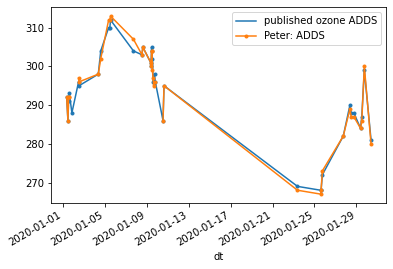

In [30]:
ax = c.query('obs_type == 1 and month == 1')\
    .plot(x = 'dt', y = 'ozone', label = 'published ozone ADDS', style = '.-')
ds.plot(x = 'dt', y = 'AD1', ax = ax, label = 'Peter: ADDS', style = '.-')

# Emailed to Jon

<AxesSubplot:xlabel='dt'>

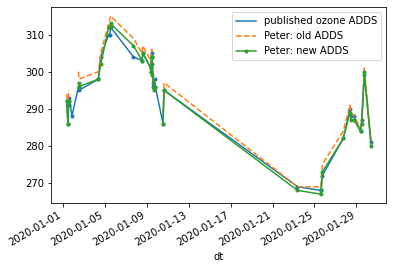

In [104]:
ax = c.query('obs_type == 1 and month == 1')\
    .plot(x = 'dt', y = 'ozone', label = 'published ozone ADDS', style = '.-')
ds.plot(x = 'dt', y = 'AD', ax = ax, label = 'Peter: old ADDS', style = '--')
ds.plot(x = 'dt', y = 'AD1', ax = ax, label = 'Peter: new ADDS', style = '.-')
